# 3.4 - Batch normalization

In [1]:
!wget -nc --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2021.deeplearning/main/content/init.py
import init; init.init(force_download=False); 

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext tensorboard

from sklearn.datasets import *
from local.lib import mlutils
tf.__version__

'2.4.0'

In [3]:
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from local.lib import mlutils
%matplotlib inline




## Batch Normalization


**Covariate shift**: Change of distribution of input to a function:

- in input data it happens when using new data
- in intermediate layers happens **ALSO** when previous layers change weights when training.

**Batch Normalizations** fixes the covariate shift:
- just before the linear network output is fed to the activation function
- or just after (less used)

Recall the activation of any layer $l$:

$$z^{[l]} = a^{[l-1]}W^{[l]} + b^{[l]}$$
$$a^{[l]} = \text{activation}(z^{[l]})$$

where $a^{[l-1]}$ is the activation (output) of the previous layer, $W^{[l]}$ and $b^{[l]}$ are the layer weights, and $\text{activation}$ is the activation function of that layer (relu, sigmoid, etc.). If layer $l$ has $n_l$ neurons, then $z^{[l]}$ is a vector of $n_l$ elements, just as $b^{[l]}$ and $a^{[l]}$

if we normalize just before the activation function, we normalize $z^{[l]}$ by substracting its mean and dividing by the standard deviation

$$\mu^{[l]} = \frac{1}{n_l}\sum_{i=0}^{n_l-1} z^{[l](i)}$$
$$\sigma^{[l]} = \frac{1}{n_l}\sum_{i=0}^{n_l-1} (z^{[l](i)}-\mu^{[l]})^2$$

so that:

$$\tilde{z}^{[l](i)} = \frac{z^{[l](i)}-\mu^{[l]}}{\sqrt{\sigma^{[l]}+\epsilon}}$$

where, $\epsilon$ is a small number (such as `1e-3`) for numerical stability in case the variace is very close to zero.

**Scaling**

Actually, we allow the normalization to have mean and std different from 0 and 1 respectively.

$$\tilde{z}^{[l](i)} = \gamma^{[l]}\tilde{z}^{[l](i)}+\beta^{[l]}$$

where $\gamma^{[l]}$ and $\beta^{[l]}$ are parameters learnable during training (with gradients, etc.)

**Test data**

When using test data, it might not have much sense to compute $\mu$ and $\sigma$ for small batches (at the extreme the batch size could even be 1, to obtain a prediction for a single data point). In these cases, a running averate of both $\mu$ and $\sigma$  are kept during training and the used in test.

**Other issues**

- BN can be seen as a mild form of regularization, since using $\mu$ and $\sigma$ for every batch introduces some noise during training (such as dropout)

- $\beta^{[l]}$ will subsume the bias parameter of the layer, as they end up being scaled and summed without depending on the data. They both act as constants which can be integrated in a single constant parameter.

See 

- [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/pdf/1502.03167.pdf)

- [Batch normalization: theory and how to use it with Tensorflow](https://towardsdatascience.com/batch-normalization-theory-and-how-to-use-it-with-tensorflow-1892ca0173ad)

- [CS231n Convolutional Neural Networks](http://cs231n.github.io/neural-networks-2/)


## Observe how we use TF Low Level API and custom optimization to see the covariate shift on  $z^{[l]}$ during training

- this could have been done also with the high level API and custom tensorboard summarizers

**We are using again a small dataset based on [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)**

In [4]:
!wget -nc https://s3.amazonaws.com/rlx/mini_cifar.h5

--2021-01-09 19:14:06--  https://s3.amazonaws.com/rlx/mini_cifar.h5
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.94.197
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.94.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14803609 (14M) [binary/octet-stream]
Saving to: ‘mini_cifar.h5’

mini_cifar.h5       100%[===================>]  14.12M  3.79MB/s    in 4.0s    

2021-01-09 19:14:10 (3.50 MB/s) - ‘mini_cifar.h5’ saved [14803609/14803609]



In [5]:
import h5py
with h5py.File('mini_cifar.h5','r') as h5f:
    x_cifar = h5f["x"][:]
    y_cifar = h5f["y"][:]

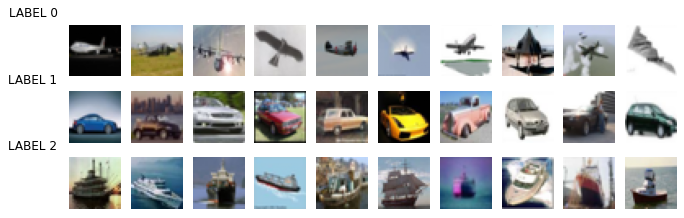

In [6]:
mlutils.show_labeled_image_mosaic(x_cifar, y_cifar)

In [7]:
print(np.min(x_cifar), np.max(x_cifar))

0.0 1.0


In [8]:
from sklearn.model_selection import train_test_split

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x_cifar, y_cifar, test_size=.25)
num_classes = len(np.unique(y_train))
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print("\ndistribution of train classes")
print(pd.Series(y_train).value_counts())
print("\ndistribution of test classes")
print(pd.Series(y_test).value_counts())
print("\nnum classes", num_classes)
x_train = x_train.astype(np.float32)
y_train = y_train.astype(np.float32)
x_test = x_test.astype(np.float32)
y_test = y_test.astype(np.float32)



(2253, 32, 32, 3) (2253,) (751, 32, 32, 3) (751,)

distribution of train classes
0    762
2    758
1    733
dtype: int64

distribution of test classes
2    267
0    243
1    241
dtype: int64

num classes 3


flatten data

In [10]:
x_trainf = np.r_[[i.flatten() for i in x_train]]
x_testf  = np.r_[[i.flatten() for i in x_test]]
x_trainf.shape, x_testf.shape

((2253, 3072), (751, 3072))

### Set up a model with Keras and train

In [11]:
from tensorflow.keras import Model
from tensorflow.keras.activations import relu, sigmoid, tanh, linear, softmax
from progressbar import progressbar as pbar
from scipy.stats import gaussian_kde

class MyModel(Model):
    def __init__(self, bn1=False, bn2=False):
        super(MyModel, self).__init__()
        self.bn1 = bn1
        self.bn2 = bn2
            
    def build(self, input_shape):
        
        self.w1 = self.add_weight(shape=(input_shape[-1], 100), initializer='random_normal', trainable=True, dtype=tf.float32)
        self.b1 = self.add_weight(shape=(100, ), initializer='random_normal', trainable=True, dtype=tf.float32)        
        
        self.w2 = self.add_weight(shape=(100, 3), initializer='random_normal', trainable=True, dtype=tf.float32)
        self.b2 = self.add_weight(shape=(3, ), initializer='random_normal', trainable=True, dtype=tf.float32)        

        
    @tf.function
    def get_z1(self, X):
        return tf.matmul(X,self.w1)+self.b1
                
    @tf.function
    def get_z2(self, X):
        z1 = self.get_z1(X)
        a1 = relu(z1)
        return tf.matmul(a1,self.w2)+self.b2
        
    @tf.function
    def call(self, X):
        z2 = self.get_z2(X)
        a2 = softmax(z2)        
        return a2
        
    @tf.function
    def train_step(self, X,y):
        preds = model(X)
        with tf.GradientTape() as tape:
            loss_value = tf.reduce_mean(self.loss(model(X), y))
        grads = tape.gradient(loss_value, self.trainable_variables)

        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return loss_value

    def fit(self, X,y, epochs=10, batch_size=32):
        self.hloss = []
        self.hz1 = []
        self.hz2 = []
        for epoch in pbar(range(epochs)):
            idxs = np.random.permutation(len(X))
            for step in range(len(X)//batch_size+((len(X)%batch_size)!=0)):
                X_batch = X[idxs][step*batch_size:(step+1)*batch_size]
                y_batch = y[idxs][step*batch_size:(step+1)*batch_size]
                loss_value = self.train_step(X_batch, y_batch)
                self.hz1.append(self.get_z1(X_batch).numpy().flatten())
                self.hz2.append(self.get_z2(X_batch).numpy().flatten())
                self.hloss.append(loss_value)
    
    def score(self, X, y):
        return np.mean(model.predict(X).argmax(axis=1) == y)    
    
    def plot_hist(self):
        def plot_z_history(s):
            s = s[::5]
            for i,data in enumerate(pbar(s)):
                kde = gaussian_kde(data)
                xrange = np.linspace(np.min(data), np.max(data),100)
                plt.plot(xrange, kde(xrange)-i*.005, 
                         color=plt.cm.RdBu(255*i/len(s)), 
                         alpha=.5)
            plt.yticks([0,-i*.005], [0,len(model.hz1)]);
            plt.ylabel("step nb")
            plt.xlabel("activation")
            plt.grid();
        plt.figure(figsize=(15,3))
        plt.subplot(131)
        plt.plot(self.hloss); plt.grid(); plt.title("loss"); plt.xlabel("steps")
        plt.subplot(132)
        plot_z_history(self.hz1); plt.title("z1 (before activation function at layer 1)\nred signals the first epoch")
        plt.subplot(133)
        plot_z_history(self.hz2); plt.title("z2 (before activation function at layer 2)\nred signals the first epoch")

In [12]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import categorical_crossentropy


100% (10 of 10) |########################| Elapsed Time: 0:00:04 Time:  0:00:04
 19% (7 of 36) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

train accuracy 0.514
test  accuracy 0.479


100% (36 of 36) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (36 of 36) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


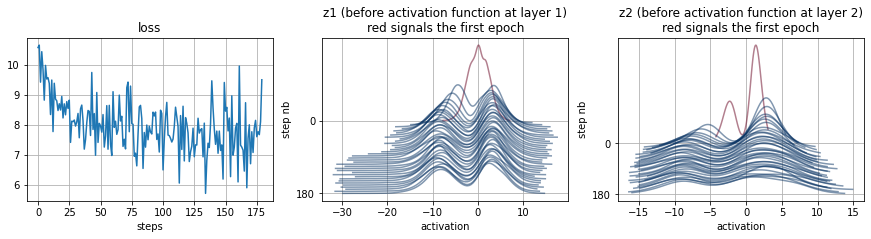

In [13]:
model = MyModel()
model.compile(optimizer="adam", loss=categorical_crossentropy)
model.fit(x_trainf, np.eye(3)[y_train.astype(int)], epochs=10, batch_size=128)
print ("train accuracy %.3f"%model.score(x_trainf, y_train))
print ("test  accuracy %.3f"%model.score(x_testf, y_test))
model.plot_hist()